In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt

In [2]:
file_path = Path("../data/example_data.hd5")
df = pd.read_hdf(file_path)
df = df.reset_index()
df.head()

,PropertyID,DateTime,Value
0,300468,2020-01-01 00:00:00,65.992325
1,300468,2020-01-01 00:00:30,59.085239
2,300468,2020-01-01 00:01:00,63.399876
3,300468,2020-01-01 00:01:30,74.437500
4,300468,2020-01-01 00:02:00,60.391750


In [3]:
df = df.pivot(index='DateTime', columns='PropertyID', values='Value')
df.columns = [str(col) for col in df.columns]
df = df.reset_index()
df.rename(columns={'DateTime':'date'}, inplace=True)
df = df.sort_values(by='date')
df.head()


,date,300468,300498,305256,315036,340686,341124,341550
0,2020-01-01 00:00:00,65.992325,2036.845581,58.777546,114.388023,1.737929,5.342316,1.386370
1,2020-01-01 00:00:30,59.085239,NaN,67.127098,NaN,1.691197,5.378604,1.403499
2,2020-01-01 00:01:00,63.399876,2036.780151,72.960365,114.293983,1.861186,5.308666,1.416289
3,2020-01-01 00:01:30,74.437500,NaN,71.723625,NaN,1.830390,5.459568,1.512679
4,2020-01-01 00:02:00,60.391750,2036.780518,70.489014,114.120377,1.729635,5.588947,1.548172


In [4]:
df.isnull().sum()

date         0
300468      20
300498    1433
305256      17
315036    1573
340686      17
341124      15
341550      17
dtype: int64

## Gap Filling Methods

### 1. Gaussian Process Regressor

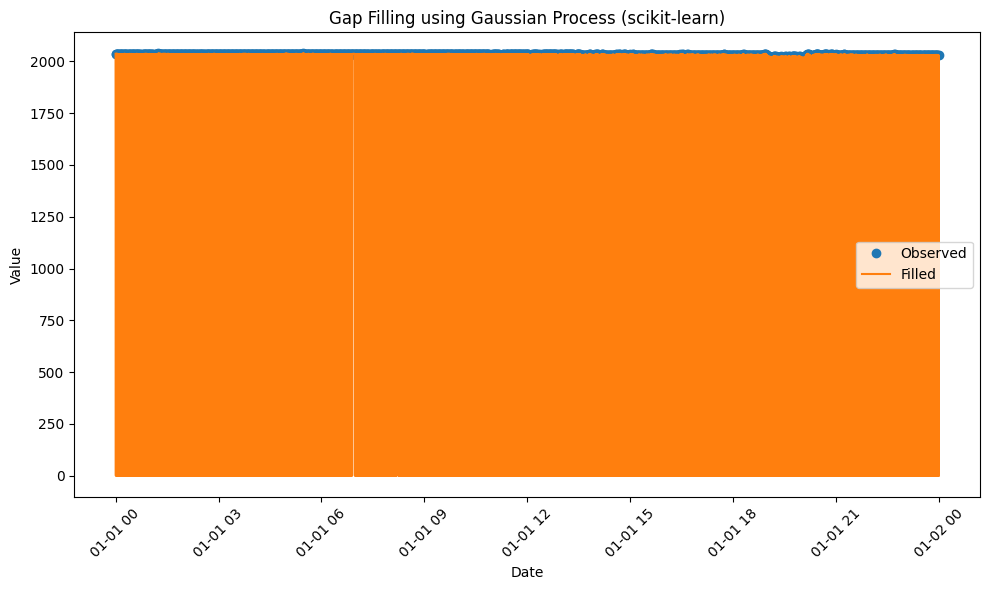

In [5]:
dates = pd.to_datetime(df["date"])
observed_values = df["300498"].values

# Find indices of missing values
missing_indices = np.where(np.isnan(observed_values))[0]

# Create a time array based on the dates
time_series = np.arange(len(dates))

# Remove missing values temporarily for training
observed_values_filled = observed_values.copy()
observed_values_filled[missing_indices] = 0

# Scaling the data (mean 0, standard deviation 1)
mean = np.mean(observed_values_filled)
std = np.std(observed_values_filled)
observed_values_scaled = (observed_values_filled - mean) / std

# Gaussian process regression
kernel = 1.0 * RBF(length_scale=10.0)
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp_model.fit(time_series[:, None], observed_values_scaled)

# Predict missing values using the Gaussian process model
mean_pred_scaled, _ = gp_model.predict(time_series[:, None], return_std=True)

# Scale back the predictions
mean_pred = (mean_pred_scaled * std) + mean

# Fill the gaps with predicted values
filled_values = observed_values.copy()
filled_values[missing_indices] = mean_pred[missing_indices]

# Plot the original, observed, and filled time series
plt.figure(figsize=(10, 6))
plt.plot(dates, observed_values, 'o', label='Observed')
plt.plot(dates, filled_values, label='Filled')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Gap Filling using Gaussian Process (scikit-learn)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
filled_data = pd.DataFrame({'date': dates, 'filled_value': filled_values})
filled_data.head()

,date,filled_value
0,2020-01-01 00:00:00,2.036846e+03
1,2020-01-01 00:00:30,1.018722e-07
2,2020-01-01 00:01:00,2.036780e+03
3,2020-01-01 00:01:30,1.018722e-07
4,2020-01-01 00:02:00,2.036781e+03


###### Gaussian Process interpolation might not be the most suitable approach due to the high level of irregularity in the missing data pattern

### 2. Linear Interpolation

In [7]:
data = df[["date","300498"]].copy()
data.set_index('date', inplace=True)

                          300498
date                            
2020-01-01 00:00:00  2036.845581
2020-01-01 00:00:30  2036.812866
2020-01-01 00:01:00  2036.780151
2020-01-01 00:01:30  2036.780334
2020-01-01 00:02:00  2036.780518


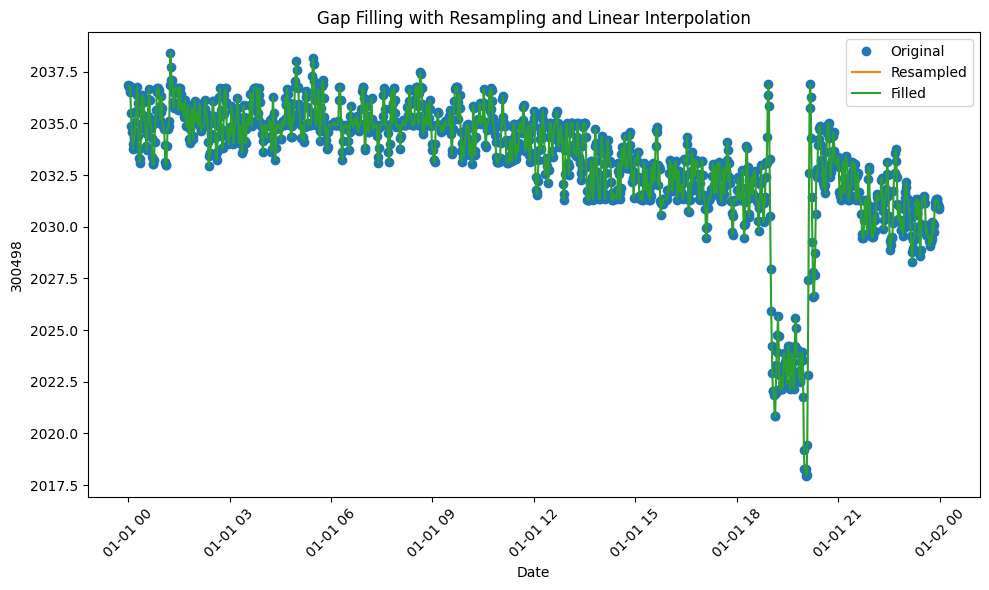

In [8]:
# Resample to 1-minute intervals and interpolate gaps
resampled_data = data.resample('30S').mean()  # You can also use 'median', 'sum', etc.
filled_data = resampled_data.interpolate(method='linear')

# Plot the original, resampled, and filled time series
print(filled_data.head())
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['300498'], 'o', label='Original')
plt.plot(resampled_data.index, resampled_data['300498'], label='Resampled')
plt.plot(filled_data.index, filled_data['300498'], label='Filled')
plt.legend()
plt.xlabel('Date')
plt.ylabel('300498')
plt.title('Gap Filling with Resampling and Linear Interpolation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 3. Cubic 

                          300498
date                            
2020-01-01 00:00:00  2036.845581
2020-01-01 00:00:30  2036.802191
2020-01-01 00:01:00  2036.780151
2020-01-01 00:01:30  2036.774560
2020-01-01 00:02:00  2036.780518


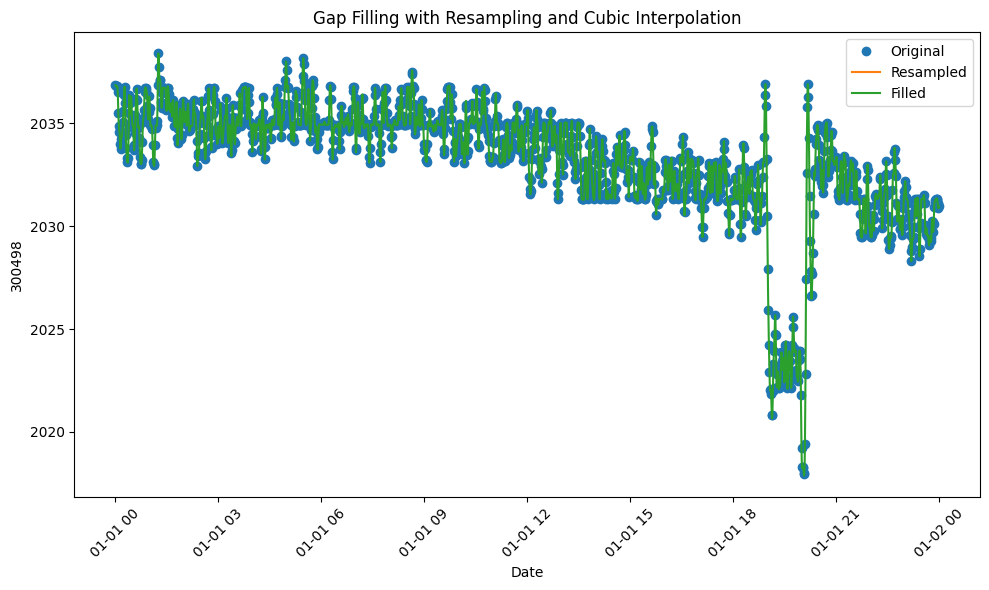

In [9]:
resampled_data = data.resample('30S').mean()  # You can also use 'median', 'sum', etc.
filled_data = resampled_data.interpolate(method='cubic')

# Plot the original, resampled, and filled time series
print(filled_data.head())
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['300498'], 'o', label='Original')
plt.plot(resampled_data.index, resampled_data['300498'], label='Resampled')
plt.plot(filled_data.index, filled_data['300498'], label='Filled')
plt.legend()
plt.xlabel('Date')
plt.ylabel('300498')
plt.title('Gap Filling with Resampling and Cubic Interpolation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### This clearly shows that Gaps in our timeseries data are best filled with all these methods

'linear'

'time'

'index'

'values'

'nearest'

'zero'

'slinear'

'quadratic'

'cubic'

'barycentric'

'krogh'

'spline'

'polynomial'

'from_derivatives'

'piecewise_polynomial'

'pchip'

'akima'

'cubicspline'

In [11]:
file_path = Path("../data/example_data.hd5")
df = pd.read_hdf(file_path)
print(df.dtypes)
print(df.head())
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.reset_index()
df = df.sort_values(by='DateTime')
df = df.reset_index(drop=True)
print(df.dtypes)
print(df.head())


df = df.pivot(index='DateTime', columns='PropertyID', values='Value')
df.columns = [str(col) for col in df.columns]

method = 'linear'


if method in ['linear', 'time', 'index', 'values', 'nearest', 'zero', 'slinear',
     'quadratic', 'cubic', 'barycentric', 'krogh', 'spline', 'polynomial', 'from_derivatives', 'piecewise_polynomial', 'pchip', 'akima', 'cubicspline']:

     df.interpolate(method=method,inplace=True)
     df = df.reset_index()
else:
        raise ValueError("Invalid interpolation method specified.")


df.head()


DateTime    datetime64[ns]
Value              float64
dtype: object
                      DateTime      Value
PropertyID                               
300468     2020-01-01 00:00:00  65.992325
300468     2020-01-01 00:00:30  59.085239
300468     2020-01-01 00:01:00  63.399876
300468     2020-01-01 00:01:30  74.437500
300468     2020-01-01 00:02:00  60.391750
PropertyID             int64
DateTime      datetime64[ns]
Value                float64
dtype: object
   PropertyID   DateTime      Value
0      300468 2020-01-01  65.992325
1      340686 2020-01-01   1.737929
2      305256 2020-01-01  58.777546
3      341550 2020-01-01   1.386370
4      341124 2020-01-01   5.342316


,DateTime,300468,300498,305256,315036,340686,341124,341550
0,2020-01-01 00:00:00,65.992325,2036.845581,58.777546,114.388023,1.737929,5.342316,1.386370
1,2020-01-01 00:00:30,59.085239,2036.812866,67.127098,114.341003,1.691197,5.378604,1.403499
2,2020-01-01 00:01:00,63.399876,2036.780151,72.960365,114.293983,1.861186,5.308666,1.416289
3,2020-01-01 00:01:30,74.437500,2036.780334,71.723625,114.207180,1.830390,5.459568,1.512679
4,2020-01-01 00:02:00,60.391750,2036.780518,70.489014,114.120377,1.729635,5.588947,1.548172
